In [7]:
import pandas as pd

In [8]:
train = pd.read_csv("data/train_5.csv")
test = pd.read_csv("data/test_5.csv")
df = pd.concat([train, test], sort=False)
df["score"] = df["score"] + 1
theta = pd.read_csv("output/theta.csv").rename(columns={"I": "Low", "II": "High", "III": "Average", "Unnamed: 0": "student_id"})

In [9]:
min_scores = df['score'] == 1
max_scores = df['score'] == 5

# Get students with minimum scores and their dimensions
students_with_min = df[min_scores][['student_id', 'dimension']].copy()

# Get students with maximum scores and their dimensions
students_with_max = df[max_scores][['student_id', 'dimension']].copy()

# Find students that have both min and max scores
students_with_both = pd.merge(
    students_with_min['student_id'],
    students_with_max['student_id'],
    how='inner'
).drop_duplicates()

# Calculate percentage
total_students = df['student_id'].nunique()
percentage = (len(students_with_both) / total_students) * 100



In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

def calculate_score_entropy(row):
    # Create histogram of scores (5 bins for scores 0-4)
    hist, _ = np.histogram(row.dropna(), bins=5, range=(0, 4), density=True)
    # Add small constant to avoid log(0)
    hist = hist + 1e-10
    # Normalize
    hist = hist / hist.sum()
    return entropy(hist)

# Handle duplicates by keeping maximum score for each student-dimension combination
df = df.sort_values('score').groupby(['student_id', 'dimension']).last().reset_index()

# Pivot the data to get student x dimension matrix
student_scores = df.pivot(index='student_id', columns='dimension', values='score')
student_scores["entropy"] = student_scores.apply(calculate_score_entropy, axis=1)

In [ ]:
def analyze_performance_variation(df):
    
    # Handle duplicates by keeping maximum score for each student-dimension combination
    df = df.sort_values('score').groupby(['student_id', 'dimension']).last().reset_index()
    
    # Pivot the data to get student x dimension matrix
    student_scores = df.pivot(index='student_id', columns='dimension', values='score')
    
    # Calculate entropy for each student's performance distribution

    
    student_entropy = student_scores.apply(calculate_score_entropy, axis=1)
    
    # Calculate mean score for each student
    student_means = student_scores.mean(axis=1)
    
    # Calculate standard deviation for each student
    student_stds = student_scores.std(axis=1)
    
    # Create visualizations
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Distribution of entropy values
    plt.subplot(221)
    sns.histplot(student_entropy, bins=30)
    plt.title('Distribution of Performance Entropy\nAcross Students')
    plt.xlabel('Entropy')
    plt.ylabel('Count')
    
    # 2. Entropy vs Mean Score
    plt.subplot(222)
    plt.scatter(student_means, student_entropy, alpha=0.1)
    plt.title('Entropy vs Mean Score')
    plt.xlabel('Mean Score')
    plt.ylabel('Entropy')
    
    # 3. Standard deviation vs Mean Score
    plt.subplot(223)
    plt.scatter(student_means, student_stds, alpha=0.1)
    plt.title('Standard Deviation vs Mean Score')
    plt.xlabel('Mean Score')
    plt.ylabel('Standard Deviation')
    
    # 4. Box plot of scores by dimension
    plt.subplot(224)
    student_scores.boxplot()
    plt.title('Score Distribution by Dimension')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics
    high_entropy_threshold = np.percentile(student_entropy, 75)
    high_var_students = (student_entropy > high_entropy_threshold).mean() * 100
    
    stats = {
        'mean_entropy': student_entropy.mean(),
        'std_entropy': student_entropy.std(),
        'pct_high_var': high_var_students,
        'entropy_percentiles': np.percentile(student_entropy, [25, 50, 75]),
        'correlation_entropy_mean': np.corrcoef(student_means, student_entropy)[0,1]
    }
    
    return student_entropy, student_means, student_stds, stats

# Example usage:
entropy_vals, means, stds, stats = analyze_performance_variation(df)

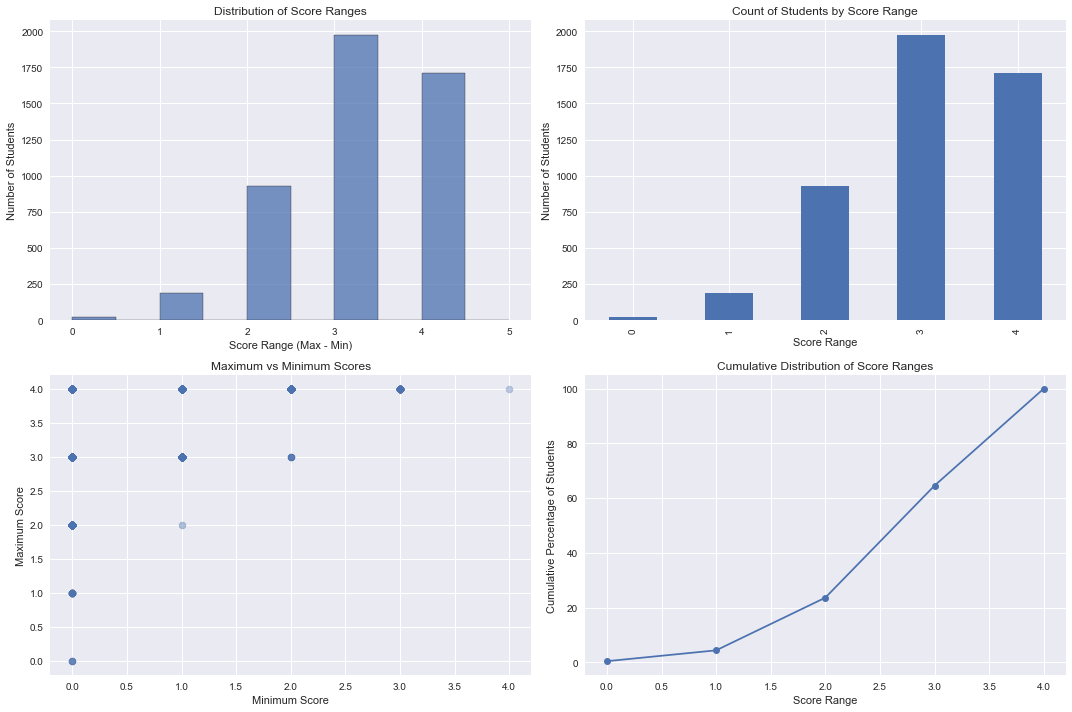


Score Range Statistics:
Number of students: 4826

Range distribution:
0      20
1     191
2     929
3    1976
4    1710
Name: score_range, dtype: int64

Percentage of students by range:
Range <= 0.0: 0.4%
Range <= 1.0: 4.4%
Range <= 2.0: 23.6%
Range <= 3.0: 64.6%
Range <= 4.0: 100.0%


In [19]:
# Calculate range for each student
ranges = df.groupby('student_id').agg({
    'score': ['min', 'max', lambda x: max(x) - min(x)]
}).reset_index()

# Rename columns
ranges.columns = ['student_id', 'min_score', 'max_score', 'score_range']

# Create visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of score ranges
sns.histplot(data=ranges, x='score_range', bins=np.arange(0, 5.5, 0.5), ax=ax1)
ax1.set_title('Distribution of Score Ranges')
ax1.set_xlabel('Score Range (Max - Min)')
ax1.set_ylabel('Number of Students')

# 2. Range value counts
range_counts = ranges['score_range'].value_counts().sort_index()
range_counts.plot(kind='bar', ax=ax2)
ax2.set_title('Count of Students by Score Range')
ax2.set_xlabel('Score Range')
ax2.set_ylabel('Number of Students')

# 3. Max vs Min scores
ax3.scatter(ranges['min_score'], ranges['max_score'], alpha=0.1)
ax3.set_title('Maximum vs Minimum Scores')
ax3.set_xlabel('Minimum Score')
ax3.set_ylabel('Maximum Score')

# 4. Cumulative distribution of ranges
range_cumsum = range_counts.sort_index().cumsum() / len(ranges) * 100
range_cumsum.plot(kind='line', marker='o', ax=ax4)
ax4.set_title('Cumulative Distribution of Score Ranges')
ax4.set_xlabel('Score Range')
ax4.set_ylabel('Cumulative Percentage of Students')
ax4.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nScore Range Statistics:")
print(f"Number of students: {len(ranges)}")
print("\nRange distribution:")
print(range_counts.sort_index())
print("\nPercentage of students by range:")
for range_val in range_counts.sort_index().index:
    pct = (ranges['score_range'] <= range_val).mean() * 100
    print(f"Range <= {range_val:.1f}: {pct:.1f}%")


Distribution of students across min-max combinations:
    min_score  max_score  count
4           0          4   1710
7           1          4   1020
3           0          3    956
9           2          4    466
2           0          2    269
6           1          3    194
10          3          4    104
1           0          1     62
8           2          3     20
0           0          0     16
5           1          2      5
11          4          4      4

Percentage of students with max range (min=0, max=4):
35.4%


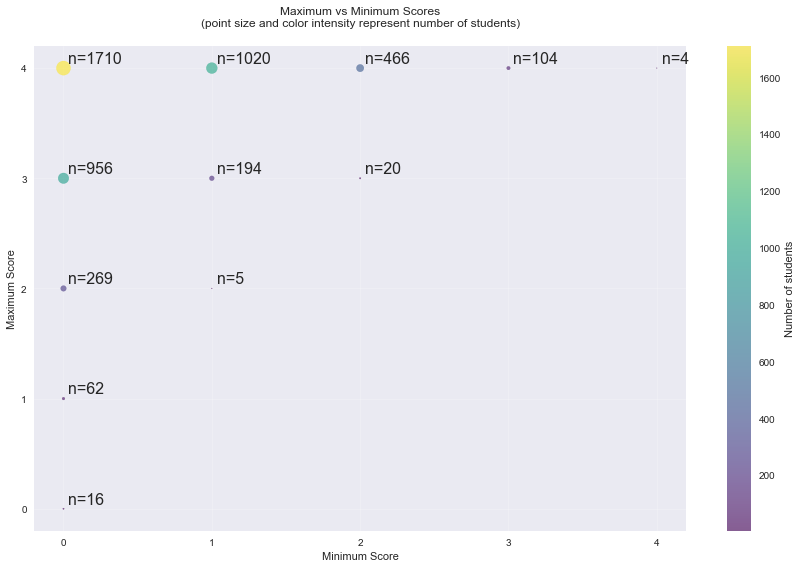

In [24]:
point_counts = ranges.groupby(['min_score', 'max_score']).size().reset_index(name='count')

# Create figure
plt.figure(figsize=(12, 8))

# Create scatter plot where size and color intensity represent count
sizes = 100 * (point_counts['count'] / point_counts['count'].max())
plt.scatter(point_counts['min_score'], 
            point_counts['max_score'],
            s=sizes * 2,
            c=point_counts['count'],
            cmap='viridis',
            alpha=0.6)

# Add count labels
for _, row in point_counts.iterrows():
    plt.annotate(f'n={int(row["count"])}', 
                (row['min_score'], row['max_score']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=16)


# Customize plot
plt.title('Maximum vs Minimum Scores\n(point size and color intensity represent number of students)',
            pad=20)
plt.xlabel('Minimum Score')
plt.ylabel('Maximum Score')

# Set integer ticks
plt.xticks(range(5))
plt.yticks(range(5))

# Add colorbar
plt.colorbar(label='Number of students')

# Add grid
plt.grid(True, alpha=0.2)

plt.tight_layout()
# plt.show()
# save the plot
plt.savefig('plots/min_max_scores.png')

# Print summary statistics
print("\nDistribution of students across min-max combinations:")
summary_df = point_counts.sort_values('count', ascending=False)
print(summary_df)

print("\nPercentage of students with max range (min=0, max=4):")
max_range_pct = point_counts[
    (point_counts['min_score'] == 0) & 
    (point_counts['max_score'] == 4)
]['count'].iloc[0] / point_counts['count'].sum() * 100
print(f"{max_range_pct:.1f}%")



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_extreme_students(scores_df, memberships_df):
    # First, identify students with extreme ranges (min=0, max=4)
    student_ranges = scores_df.groupby('student_id').agg({
        'score': ['min', 'max']
    }).reset_index()
    student_ranges.columns = ['student_id', 'min_score', 'max_score']
    
    # Get extreme students (min=0, max=4)
    extreme_students = student_ranges[
        (student_ranges['min_score'] == 0) & 
        (student_ranges['max_score'] == 4)
    ]['student_id']
    
    # Get their memberships
    extreme_memberships = memberships_df[
        memberships_df['student_id'].isin(extreme_students)
    ]
    
    # Create visualizations
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 6))

    # Distribution of dominant group for extreme students
    def get_dominant_group(row):
        groups = ['Low', 'High', 'Average']
        max_val = max(row[groups])
        dominant = [g for g in groups if row[g] == max_val]
        return dominant[0] if len(dominant) == 1 else np.nan
    
    extreme_memberships['dominant_group'] = extreme_memberships.apply(get_dominant_group, axis=1)
    extreme_memberships['dominant_group'].value_counts().plot(
        kind='bar', ax=ax1, color='skyblue'
    )
    ax1.set_title('Distribution of Dominant Groups\nfor Students with Extreme Ranges')
    ax1.set_ylabel('Number of Students')
    
    # 3. Box plots of group memberships for extreme students
    extreme_memberships_melted = extreme_memberships.melt(
        value_vars=['Low', 'High', 'Average'],
        var_name='Group',
        value_name='Membership'
    )
    sns.boxplot(data=extreme_memberships_melted, x='Group', y='Membership', ax=ax2)
    ax2.set_title('Distribution of Group Memberships\nfor Students with Extreme Ranges')
    
    plt.tight_layout()
    # save to plots
    plt.savefig('plots/extreme_students_distribution.pdf')
    
    # Print summary statistics
    print("\nSummary of students with extreme ranges:")
    print(f"Total number of extreme range students: {len(extreme_memberships)}")
    print("\nDominant group distribution:")
    print(extreme_memberships['dominant_group'].value_counts(normalize=True).mul(100))
    
    # Calculate mean memberships
    print("\nMean memberships for extreme range students:")
    print(extreme_memberships[['Low', 'High', 'Average']].mean())

<ipython-input-16-c97ec3a39a46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extreme_memberships['dominant_group'] = extreme_memberships.apply(get_dominant_group, axis=1)



Summary of students with extreme ranges:
Total number of extreme range students: 1764

Dominant group distribution:
Average    42.832667
High       41.290691
Low        15.876642
Name: dominant_group, dtype: float64

Mean memberships for extreme range students:
Low        0.242503
High       0.409737
Average    0.347760
dtype: float64


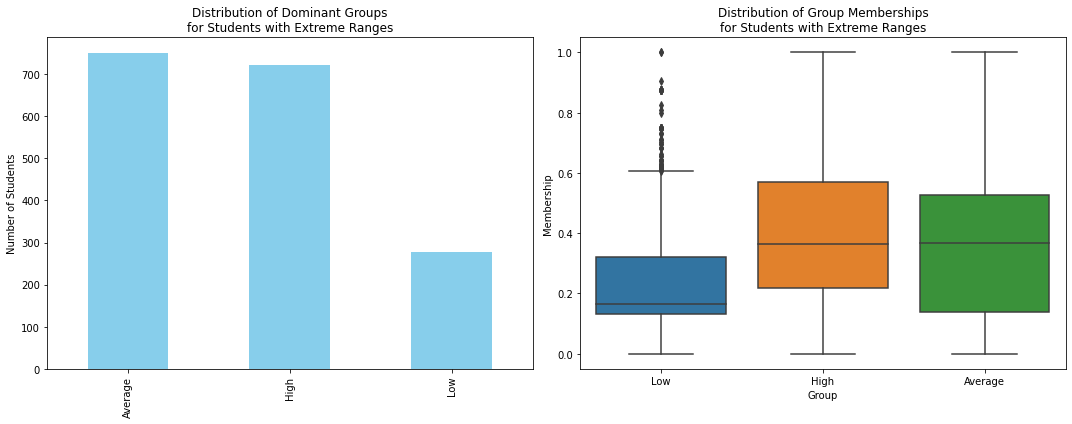

In [17]:
analyze_extreme_students(df, theta)

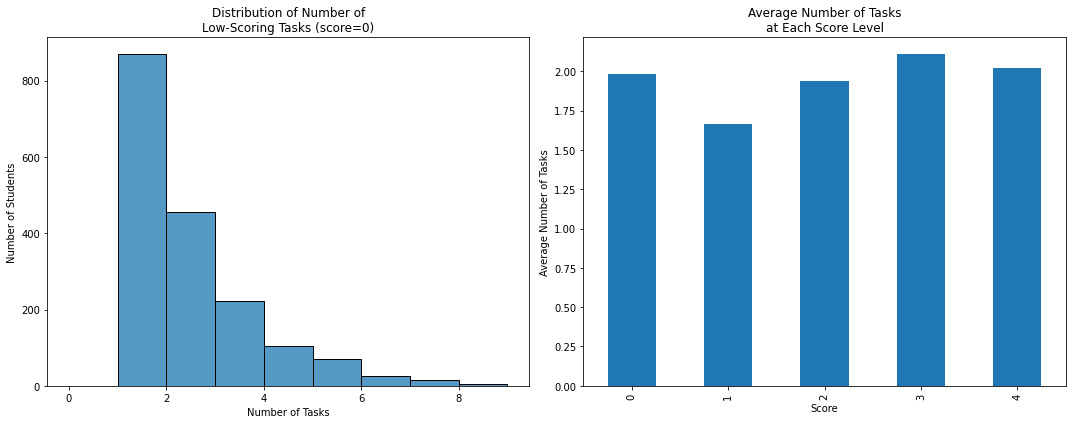


Distribution of number of low-scoring tasks (score=0):
1    870
2    455
3    222
4    104
5     69
6     25
7     14
8      5
Name: 0, dtype: int64

Mean number of tasks at each score level:
score
0    1.981293
1    1.663265
2    1.938209
3    2.109977
4    2.018141
dtype: float64


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_task_patterns(scores_df):
    # Get students with extreme ranges (min=0, max=4)
    student_ranges = scores_df.groupby('student_id').agg({
        'score': ['min', 'max']
    }).reset_index()
    student_ranges.columns = ['student_id', 'min_score', 'max_score']
    extreme_students = student_ranges[
        (student_ranges['min_score'] == 0) & 
        (student_ranges['max_score'] == 4)
    ]['student_id']
    
    # Get scores for extreme students
    extreme_scores = scores_df[scores_df['student_id'].isin(extreme_students)]
    
    # Count tasks with each score for each student
    score_counts = extreme_scores.groupby('student_id')['score'].value_counts().unstack(fill_value=0)
    
    # Create visualizations
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Distribution of number of low-scoring tasks
    low_scores = score_counts[0]  # Count of score=0 tasks
    sns.histplot(data=low_scores, bins=range(max(low_scores)+2), ax=ax1)
    ax1.set_title('Distribution of Number of\nLow-Scoring Tasks (score=0)')
    ax1.set_xlabel('Number of Tasks')
    ax1.set_ylabel('Number of Students')
    
    # 2. Average distribution of scores
    mean_counts = score_counts.mean()
    mean_counts.plot(kind='bar', ax=ax2)
    ax2.set_title('Average Number of Tasks\nat Each Score Level')
    ax2.set_xlabel('Score')
    ax2.set_ylabel('Average Number of Tasks')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nDistribution of number of low-scoring tasks (score=0):")
    print(low_scores.value_counts().sort_index())
    
    print("\nMean number of tasks at each score level:")
    print(mean_counts)
    
    return score_counts

# Example usage:
task_counts = analyze_task_patterns(df)


Extreme range students (N=1764):
   Count  Percentage
1    870   49.319728
2    455   25.793651
3    222   12.585034
4    104    5.895692
5     69    3.911565
6     25    1.417234
7     14    0.793651
8      5    0.283447

Non-extreme range students (N=3062):
    Count  Percentage
0    1758   57.413455
1     275    8.981058
2     260    8.491182
3     204    6.662312
4     176    5.747877
5     128    4.180274
6     109    3.559765
7      62    2.024820
8      56    1.828870
9      25    0.816460
10      9    0.293926


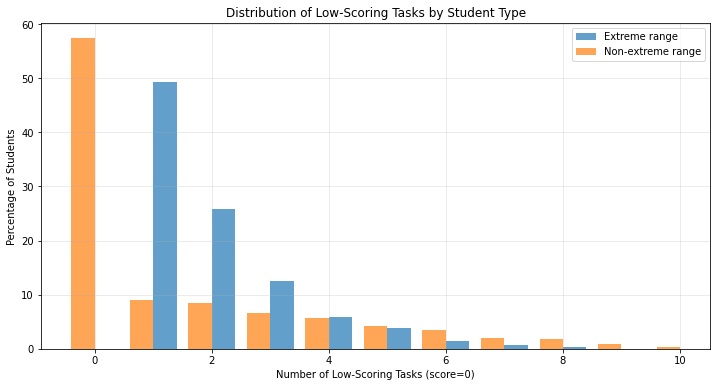

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_low_scores(scores_df):
    # Identify student groups
    student_ranges = scores_df.groupby('student_id').agg({
        'score': ['min', 'max']
    }).reset_index()
    student_ranges.columns = ['student_id', 'min_score', 'max_score']
    
    # Create student type indicator
    student_ranges['type'] = 'Non-extreme range'
    student_ranges.loc[
        (student_ranges['min_score'] == 0) & 
        (student_ranges['max_score'] == 4),
        'type'
    ] = 'Extreme range'
    
    # Count low scores for each student
    score_counts = scores_df.groupby('student_id')['score'].value_counts().unstack(fill_value=0)
    low_scores = score_counts[0].reset_index()  # Count of score=0 tasks
    
    # Merge with student type
    low_scores = low_scores.merge(
        student_ranges[['student_id', 'type']], 
        on='student_id'
    )
    
    # Create plot
    plt.figure(figsize=(12, 6))
    
    # Calculate and plot percentages for each group
    for student_type in ['Extreme range', 'Non-extreme range']:
        group_data = low_scores[low_scores['type'] == student_type][0]
        total_students = len(group_data)
        percentages = group_data.value_counts().sort_index() / total_students * 100
        
        plt.bar(percentages.index + (0.2 if student_type == 'Extreme range' else -0.2), 
                percentages, 
                width=0.4,
                label=student_type,
                alpha=0.7)
    
    plt.xlabel('Number of Low-Scoring Tasks (score=0)')
    plt.ylabel('Percentage of Students')
    plt.title('Distribution of Low-Scoring Tasks by Student Type')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Print summary statistics
    for student_type in ['Extreme range', 'Non-extreme range']:
        group_data = low_scores[low_scores['type'] == student_type][0]
        print(f"\n{student_type} students (N={len(group_data)}):")
        counts = group_data.value_counts().sort_index()
        percentages = counts / len(group_data) * 100
        summary = pd.DataFrame({
            'Count': counts,
            'Percentage': percentages
        })
        print(summary)
    
    plt.show()

# Example usage:
analyze_low_scores(df)


High Performers (N=1778)
   count  group_pct  total_pct
0   1044  58.717660  21.632822
1    474  26.659168   9.821799
2    189  10.629921   3.916287
3     50   2.812148   1.036055
4     19   1.068616   0.393701
5      1   0.056243   0.020721
6      1   0.056243   0.020721

Low Performers (N=783)
   count  group_pct  total_pct
0    492  62.835249  10.194778
1    179  22.860792   3.709076
2     86  10.983397   1.782014
3     22   2.809706   0.455864
4      3   0.383142   0.062163
6      1   0.127714   0.020721

Average Performers (N=2265)


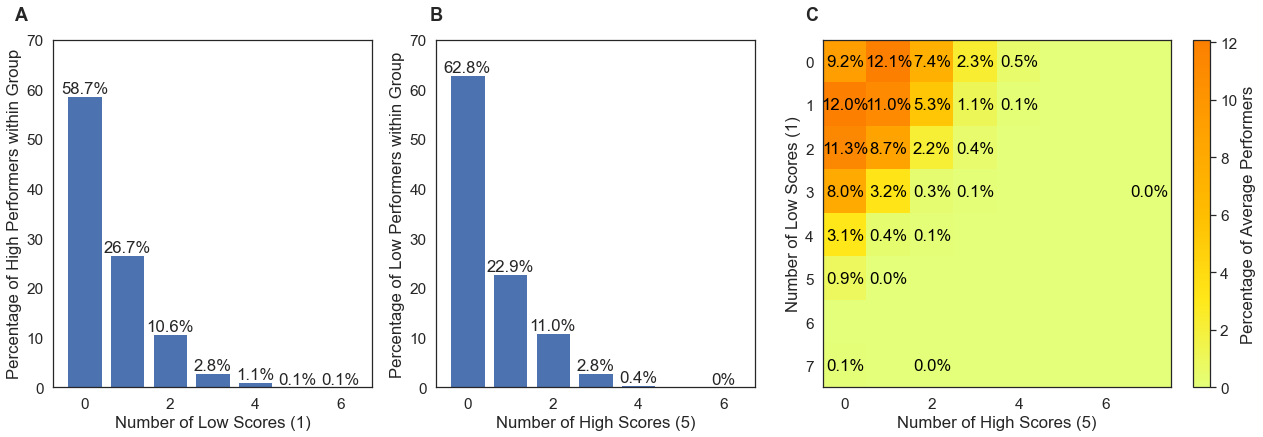

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
import numpy as np

sns.set_theme(font_scale=1.4, style="white")


def analyze_group_extremes(scores_df, memberships_df):
    
    # Merge scores with memberships
    student_scores = scores_df.groupby('student_id').agg({
        'score': ['min', 'max', list]
    }).reset_index()
    student_scores.columns = ['student_id', 'min_score', 'max_score', 'scores']
    
    df = student_scores.merge(memberships_df, left_on='student_id', right_on='student_id')
    
    # Determine dominant group for each student
    groups = ['Low', 'High', 'Average']
    df['dominant_group'] = df[groups].idxmax(axis=1)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), 
                                   gridspec_kw={'width_ratios': [0.725, 0.725, 1]})
    fig.text(0.02, 0.99, 'A', fontsize=18, fontweight='bold')
    fig.text(0.34, 0.99, 'B', fontsize=18, fontweight='bold')
    fig.text(0.63, 0.99, 'C', fontsize=18, fontweight='bold')
    
    # Function to calculate both percentages
    def get_percentages(data, values):
        group_counts = data.value_counts().sort_index()
        group_pcts = group_counts / len(data) * 100
        total_pcts = group_counts / len(df) * 100
        return pd.DataFrame({
            'count': group_counts,
            'group_pct': group_pcts,
            'total_pct': total_pcts
        })
    
    # 1. High performers - distribution of low scores
    high_performers = df[df['dominant_group'] == 'High']
    low_scores_high = high_performers['scores'].apply(lambda x: sum(s == 1 for s in x))
    high_stats = get_percentages(low_scores_high, range(max(low_scores_high) + 1))
    
    bars1 = ax1.bar(high_stats.index, high_stats['group_pct'])
    # ax1.set_title('High Performers:\nDistribution of Low-Scoring Tasks')
    ax1.set_xlabel('Number of Low Scores (1)')
    ax1.set_ylabel('Percentage of High Performers within Group')
    ax1.set_ylim(0, 70)

    # Add percentage labels
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{high_stats["group_pct"][i]:.1f}%',
                ha='center', va='bottom')
    
    # 2. Low performers - distribution of high scores
    low_performers = df[df['dominant_group'] == 'Low']
    high_scores_low = low_performers['scores'].apply(lambda x: sum(s == 5 for s in x))
    low_stats = get_percentages(high_scores_low, range(max(high_scores_low) + 1))
    
    bars2 = ax2.bar(low_stats.index, low_stats['group_pct'])
    # ax2.set_title('Low Performers:\nDistribution of High-Scoring Tasks')
    ax2.set_xlabel('Number of High Scores (5)')
    ax2.set_ylabel('Percentage of Low Performers within Group')
    ax2.set_ylim(0, 70)
    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        try:
            ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{low_stats["group_pct"][i]:.1f}%',
                ha='center', va='bottom')
        except KeyError:
            ax2.text(bar.get_x() + bar.get_width()/2, height,
                "0%",
                ha='center', va='bottom')
    
    # 3. Average performers with extreme scores
    avg_performers = df[df['dominant_group'] == 'Average']
    extreme_scores_avg = avg_performers['scores'].apply(
        lambda x: (sum(s == 1 for s in x), sum(s == 5 for s in x))
    )
    
    # Create a matrix of low vs high scores
    max_low = max(x[0] for x in extreme_scores_avg)
    max_high = max(x[1] for x in extreme_scores_avg)
    matrix = np.zeros((max_low + 1, max_high + 1))
    
    for low, high in extreme_scores_avg:
        matrix[low, high] += 1
    
    # Convert to percentages
    matrix_pct = matrix / len(avg_performers) * 100
    
    # Use YlOrRd colormap which is great for percentages and starts light
    im = ax3.imshow(matrix_pct, cmap='Wistia')
    ax3.set_xlabel('Number of High Scores (5)')
    ax3.set_ylabel('Number of Low Scores (1)')
    
    # Add percentage labels with simpler styling
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                group_pct = matrix_pct[i, j]
                ax3.text(j, i, f'{group_pct:.1f}%',
                        ha='center', va='center', color='black')
    
    plt.colorbar(im, ax=ax3, label='Percentage of Average Performers')
    plt.tight_layout()
    plt.savefig('plots/group_extremes.pdf', bbox_inches='tight')
    
    # Print summary statistics
    print("\nHigh Performers (N={})".format(len(high_performers)))
    print(high_stats)
    print("\nLow Performers (N={})".format(len(low_performers)))
    print(low_stats)
    print("\nAverage Performers (N={})".format(len(avg_performers)))

# Example usage:
analyze_group_extremes(df, theta)


High Performers (N=1778)
   count  group_pct  total_pct
0   1044  58.717660  21.632822
1    474  26.659168   9.821799
2    189  10.629921   3.916287
3     50   2.812148   1.036055
4     19   1.068616   0.393701
5      1   0.056243   0.020721
6      1   0.056243   0.020721

Low Performers (N=783)


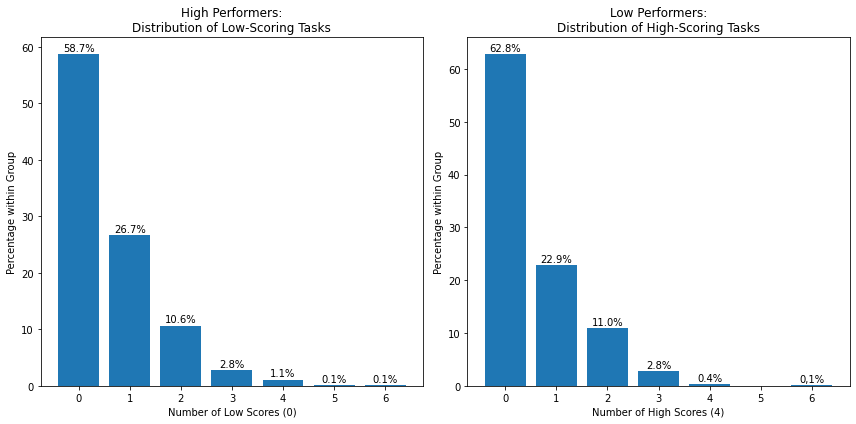

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def analyze_group_extremes(scores_df, memberships_df):
    # Merge scores with memberships
    student_scores = scores_df.groupby('student_id').agg({
        'score': ['min', 'max', list]
    }).reset_index()
    student_scores.columns = ['student_id', 'min_score', 'max_score', 'scores']
    
    df = student_scores.merge(memberships_df, left_on='student_id', right_on='student_id')
    
    # Determine dominant group for each student
    groups = ['Low', 'High', 'Average']
    df['dominant_group'] = df[groups].idxmax(axis=1)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Function to calculate both percentages
    def get_percentages(data, values):
        group_counts = data.value_counts().sort_index()
        group_pcts = group_counts / len(data) * 100
        total_pcts = group_counts / len(df) * 100
        return pd.DataFrame({
            'count': group_counts,
            'group_pct': group_pcts,
            'total_pct': total_pcts
        })
    
    # 1. High performers - distribution of low scores
    high_performers = df[df['dominant_group'] == 'High']
    low_scores_high = high_performers['scores'].apply(lambda x: sum(s == 0 for s in x))
    high_stats = get_percentages(low_scores_high, range(max(low_scores_high) + 1))
    
    bars1 = ax1.bar(high_stats.index, high_stats['group_pct'])
    ax1.set_title('High Performers:\nDistribution of Low-Scoring Tasks')
    ax1.set_xlabel('Number of Low Scores (0)')
    ax1.set_ylabel('Percentage within Group')
    
    # Add percentage labels
    for i, bar in enumerate(bars1):
        height = bar.get_height() + 0.2
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{high_stats["group_pct"][i]:.1f}%',
                ha='center', va='bottom')
    
    # 2. Low performers - distribution of high scores
    low_performers = df[df['dominant_group'] == 'Low']
    high_scores_low = low_performers['scores'].apply(lambda x: sum(s == 4 for s in x))
    low_stats = get_percentages(high_scores_low, range(max(high_scores_low) + 1))
    
    bars2 = ax2.bar(low_stats.index, low_stats['group_pct'])
    ax2.set_title('Low Performers:\nDistribution of High-Scoring Tasks')
    ax2.set_xlabel('Number of High Scores (4)')
    ax2.set_ylabel('Percentage within Group')
    
    for i, bar in enumerate(bars2):
        height = bar.get_height() + 0.2
        try:
            ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{low_stats["group_pct"][i]:.1f}%',
                ha='center', va='bottom')
        except KeyError:
            ax2.text(bar.get_x() + bar.get_width()/2, height,
                "0,1%",
                ha='center', va='bottom')
    

    plt.tight_layout()
    # export to png
    plt.savefig('plots/group_extremes.pdf')
    
    # Print summary statistics
    print("\nHigh Performers (N={})".format(len(high_performers)))
    print(high_stats)
    print("\nLow Performers (N={})".format(len(low_performers)))

# Example usage:
analyze_group_extremes(df, theta)

In [32]:
def analyze_quintiles(scores_df, memberships_df):
    # Merge scores with memberships
    student_scores = scores_df.groupby('student_id').agg({
        'score': list
    }).reset_index()
    
    df = student_scores.merge(memberships_df, left_on='student_id', right_on='student_id')
    
    # Determine dominant group for each student
    groups = ['Low', 'High', 'Average']
    df['dominant_group'] = df[groups].idxmax(axis=1)
    
    # Calculate percentages for each group
    results = {}
    for group in groups:
        group_students = df[df['dominant_group'] == group]
        total_in_group = len(group_students)
        
        # Students with highest quintile (5)
        high_quintile = sum(any(score == 5 for score in scores) 
                          for scores in group_students['score'])
        
        # Students with lowest quintile (1)
        low_quintile = sum(any(score == 1 for score in scores) 
                         for scores in group_students['score'])
        
        results[group] = {
            'total_students': total_in_group,
            'pct_highest_quintile': (high_quintile / total_in_group) * 100,
            'pct_lowest_quintile': (low_quintile / total_in_group) * 100
        }
    
    # Print results
    for group, stats in results.items():
        print(f"\n{group} performers (N={stats['total_students']}):")
        print(f"Percentage reaching highest quintile: {stats['pct_highest_quintile']:.1f}%")
        print(f"Percentage reaching lowest quintile: {stats['pct_lowest_quintile']:.1f}%")

# Example usage:
analyze_quintiles(df, theta)


Low performers (N=783):
Percentage reaching highest quintile: 37.2%
Percentage reaching lowest quintile: 100.0%

High performers (N=1778):
Percentage reaching highest quintile: 98.9%
Percentage reaching lowest quintile: 41.3%

Average performers (N=2265):
Percentage reaching highest quintile: 55.4%
Percentage reaching lowest quintile: 68.5%


In [33]:
df

,student_id,dimension,score
0,3244,reading,4
1,1031,execution_speed,1
2,1831,processing_speed,3
3,2274,processing_speed,3
4,2529,calculus,4
...,...,...,...
4821,7009,long_term_memory,1
4822,7012,emotion,4
4823,7013,reasoning,3
4824,7014,response_behaviour,5
